Testing the Gaia Challenge simulated data. The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

As a result, the $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{los}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \frac{z}{\sqrt{z^2-1}}\int^\infty_{zR}\frac{\nu_\ast(s)\mu(\frac{s}{r_0})}{s^2}dsdz
\end{equation}
Here $\beta$ = 0.
The integral above can be cast into a dimensionless form by performing the following variable transformations: $\gamma = \frac{R}{r_h}$, $y = \frac{s}{r_h}$ and $\alpha = \frac{r_h}{r_0}$.
\begin{equation}
\sigma^2_{los}(R) = 2G\mu_0\frac{\gamma}{I(R)}\int^\infty_1 \frac{z}{\sqrt{z^2-1}}\int^\infty_{z\gamma}\frac{\nu_\ast(y)\mu(y\alpha)}{y^2}dsdz
\end{equation}

In [1]:
import yaml
import numpy as np
from sys import argv
from iminuit import Minuit
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import interp1d as interp
from functions_simIS import integral2, compute_I_array, Jfactor,nu, proxy_integral2
import itertools
import time
%matplotlib inline

In [2]:
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = ['Isotrop_Core_nonPlum','Isotrop_Core_Plum','Isotrop_Cusp_nonPlum','Isotrop_Cusp_Plum']

# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100
dataSize = 100
dset=0
# enter model choice - cf. casedir (options 0,1,2,3)
mod = 3

In [3]:
D=100.
theta=0.5
with_velocity_errors=True

In [4]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh, mod)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] if mod == 1 or mod == 3 else \
rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [5]:
# Mock data preparation
if MockSize<100:
    dataSize=100
    
data = ['/data/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i.dat'%(dataSize,dset),      # Isotrop_Core_nonPlum
        '/data/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i.dat'%(dataSize,dset),      # Isotrop_Core_Plum
        '/data/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i.dat'%(dataSize,dset),      # Isotrop_Cusp_nonPlum
        '/data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i.dat'%(dataSize,dset)]      # Isotrop_Cusp_Plum
err  = ['/data/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i_err.dat'%(dataSize,dset),  # Isotrop_Core_nonPlum
        '/data/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i_err.dat'%(dataSize,dset),  # Isotrop_Core_Plum
        '/data/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i_err.dat'%(dataSize,dset),  # Isotrop_Cusp_nonPlum
        '/data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i_err.dat'%(dataSize,dset)]  # Isotrop_Cusp_Plum

x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir[mod]+data[mod],unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
d = np.sqrt(x**2+y**2+(D-z)**2)
if not with_velocity_errors:
    v = (x*vx+y*vy+(D-z)*vz)/d
    dv = np.zeros_like(v)
else:
    # Errors (from mock data) preparation
    Evx,Evy,Evz = np.loadtxt(homedir+casedir[mod]+err[mod],unpack=True,usecols=(3,4,5))
    Ex,Ey,Ez = Evx-vx, Evy-vy,Evz-vz
    v = (x*Evx+y*Evy+(D-z)*Evz)/d
    dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [6]:
if MockSize<dataSize:
    idx=np.random.randint(low=dataSize, size=MockSize)
    R,v,dv=R[idx],v[idx],dv[idx]

In [7]:
u=0.
rh= 1. if mod == 0 or mod == 1 else 0.25
r0_true=1.
rho0_true=6.4e7
J_true=np.log10(Jfactor(D,np.inf,r0_true,rho0_true, theta, mod))
print theta, D, "%g"%J_true

0.5 100.0 18.8344


In [8]:
gamma_array = R/rh
A_array = np.array([gamma_array[i]/I(Ri,rh) for i,Ri in enumerate(R)])

In [9]:
cst = 8.*np.pi*4.3e-6
class logLike:
    def __init__(self,data, numprocs=1):
        self.data = data
        self.numprocs = numprocs
        self.cache = {}
        
    def retrieve(self,r0):
        if r0 in self.cache.keys():
            I=self.cache[r0]
            iscached=True
        else:
            I=0#dummy value
            iscached=False
        return iscached, I
    
    def store(self,r0, I):
        self.cache[r0]=I
        return

    def pool_compute(self, alpha):
        from multiprocessing import Pool
        pool = Pool(processes=self.numprocs)
        results = pool.map(proxy_integral2, itertools.izip(self.data, itertools.repeat(alpha), mod))
        pool.close()
        pool.join()
        return results
    
    def compute(self,J,r0):
        #treat r0 first, as it can't be vectorized
        r0=10**r0
        if r0<=0:
            if np.isscalar(J):
                return np.nan
            else:
                return np.nan*np.ones_like(J)
        J=np.asarray(J)
        if np.all(J<0):
            return np.nan*np.ones_like(J)
        else:
            res=np.zeros_like(J)
            mask=J>0
            res[np.logical_not(mask)]=np.nan
            iscached, Icached = self.retrieve(r0)
            if iscached:
                I=Icached
            else:
                if self.numprocs==1 or self.data.size<100:
                    #I_array = compute_I_array(self.data, rh/r0)
                    I_array = np.array([integral2(gamma, rh/r0, mod) for gamma in self.data])
                else:
                    I_array = self.pool_compute(rh/r0)
                I = cst*r0**3*A_array*I_array/np.sqrt(Jfactor(D,np.inf,r0,1.,theta,mod))
                self.store(r0,I)
            S = (dv**2.)[:,np.newaxis] + I[:,np.newaxis] * np.power(10,J/2.)
        res = (np.log(S) + ((v-u)**2.)[:,np.newaxis]/S)
        res = res.sum(axis=0)
        return res/2.

In [11]:
lh = logLike(gamma_array)
settings = {'errordef':0.5,'print_level':0,'pedantic':False,'J':19,'r0':np.log10(rh*2.),'error_J':0.001,'error_r0':0.0001}
Jfit = Minuit(lh.compute,**settings)
Jfit.tol = 0.001
Jfit.set_strategy(2)
BF = Jfit.migrad()

In [ ]:
minL = BF[0]['fval']
J_min,eJ_min = BF[1][0]['value'],BF[1][0]['error']
J_r0, eJ_r0 = BF[1][1]['value'],BF[1][1]['error']
print 'J  = ',J_min,'+-',eJ_min
print 'r0 = ',10**J_r0,'+-',10**eJ_r0

In [18]:
r0_array = np.linspace(-2,4,100)
J_array = J_min+eJ_min*np.arange(-4,+5+0.05,0.05)

In [19]:
res = np.zeros(shape=(len(r0_array), len(J_array)))
for i,r0 in enumerate(r0_array):
        res[i,:] = lh.compute(J_array,r0)-minL

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg)


In [20]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    ticks = {'0.5':1,'2.0':2,'4.5':3}
    return r'${}\sigma$'.format(ticks[format(x)])

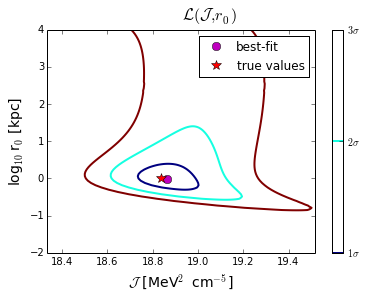

In [23]:
plt.contour(J_array, r0_array,res,[0.5,2.,4.5],linewidths=2)
plt.colorbar(format=ticker.FuncFormatter(fmt))
plt.plot(J_min,J_r0,'mo',label='best-fit',markersize=8)
plt.plot(J_true, np.log10(r0_true), 'r*',label='true values',markersize=10)
plt.xlabel(r'$\mathcal{J}$ [MeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylabel(r'log$_{10}$ r$_0$ [kpc]',fontsize=14)
plt.legend(numpoints=1).get_frame().set_facecolor('w')
plt.suptitle(r'$\mathcal{L}(\mathcal{J},r_0)$',fontsize=16)
#plt.savefig('IS_J_r0_cont.png',dpi=300,format='png')

In [437]:
#J_arr,Like_arr,res2 = Jfit.mnprofile('J',bound=3,subtract_min=True)

In [421]:
#plt.plot(J_arr,Like_arr)